In [1]:
from tqdm.notebook import tqdm

import jax
import optax

from dart import dataset, VirtualRadar, fields, DART

In [2]:
sensor = VirtualRadar.from_config("data/sim_96.json", n=256, k=128)

gt = dataset.gt_map("data/map.mat")
ds = dataset.dart("data/traj.mat", "data/sim_96.npz", sensor, pre_shuffle=True)
ds = ds.shuffle(100000, reshuffle_each_iteration=True)

In [3]:
optimizer = optax.adamw(optax.exponential_decay(
    0.01, 500, 0.01, transition_begin=100, end_value=0.001))

def sigma():
    return fields.SimpleGrid(
        (100, 100, 100), lower=gt.lower * 2, resolution=gt.resolution) 
dart = DART(sensor, optimizer, sigma)
state = dart.init(jax.random.PRNGKey(42), ds.batch(2))

In [4]:
state = dart.fit(jax.random.PRNGKey(42), ds.batch(2048), state, epochs=1, tqdm=tqdm)

Epoch 0:   0%|          | 0/441 [00:00<?, ?batch/s]

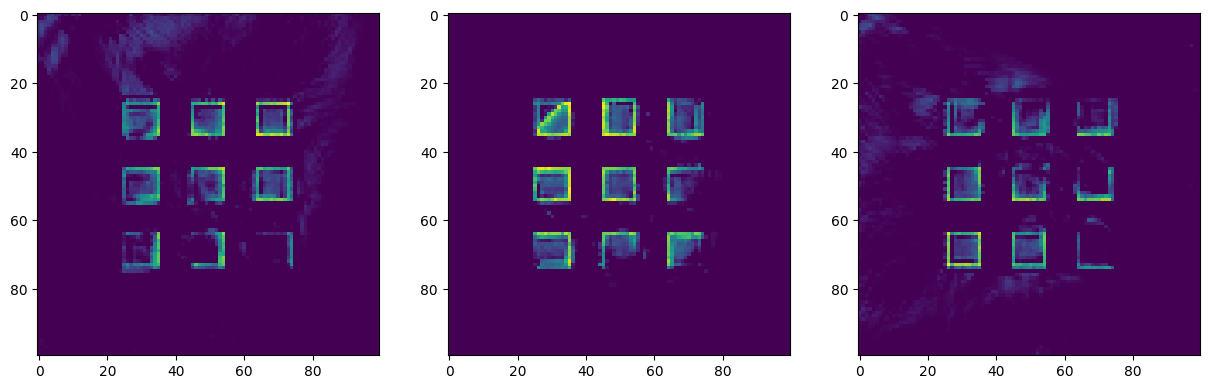

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([30, 50, 70], axs):
    ax.imshow(state.params['simple_grid']['grid'][:, :, layer])

In [6]:
from jax import numpy as jnp

traj = dataset.image_traj("data/traj.mat", "data/sim_96.npz")
poses, images = list(traj.shuffle(10000).batch(64).take(1))[0]
poses_jnp = jax.tree_util.tree_map(jnp.array, poses)
predicted = jax.jit(dart.model.apply)(state.params, jax.random.PRNGKey(42), poses_jnp)

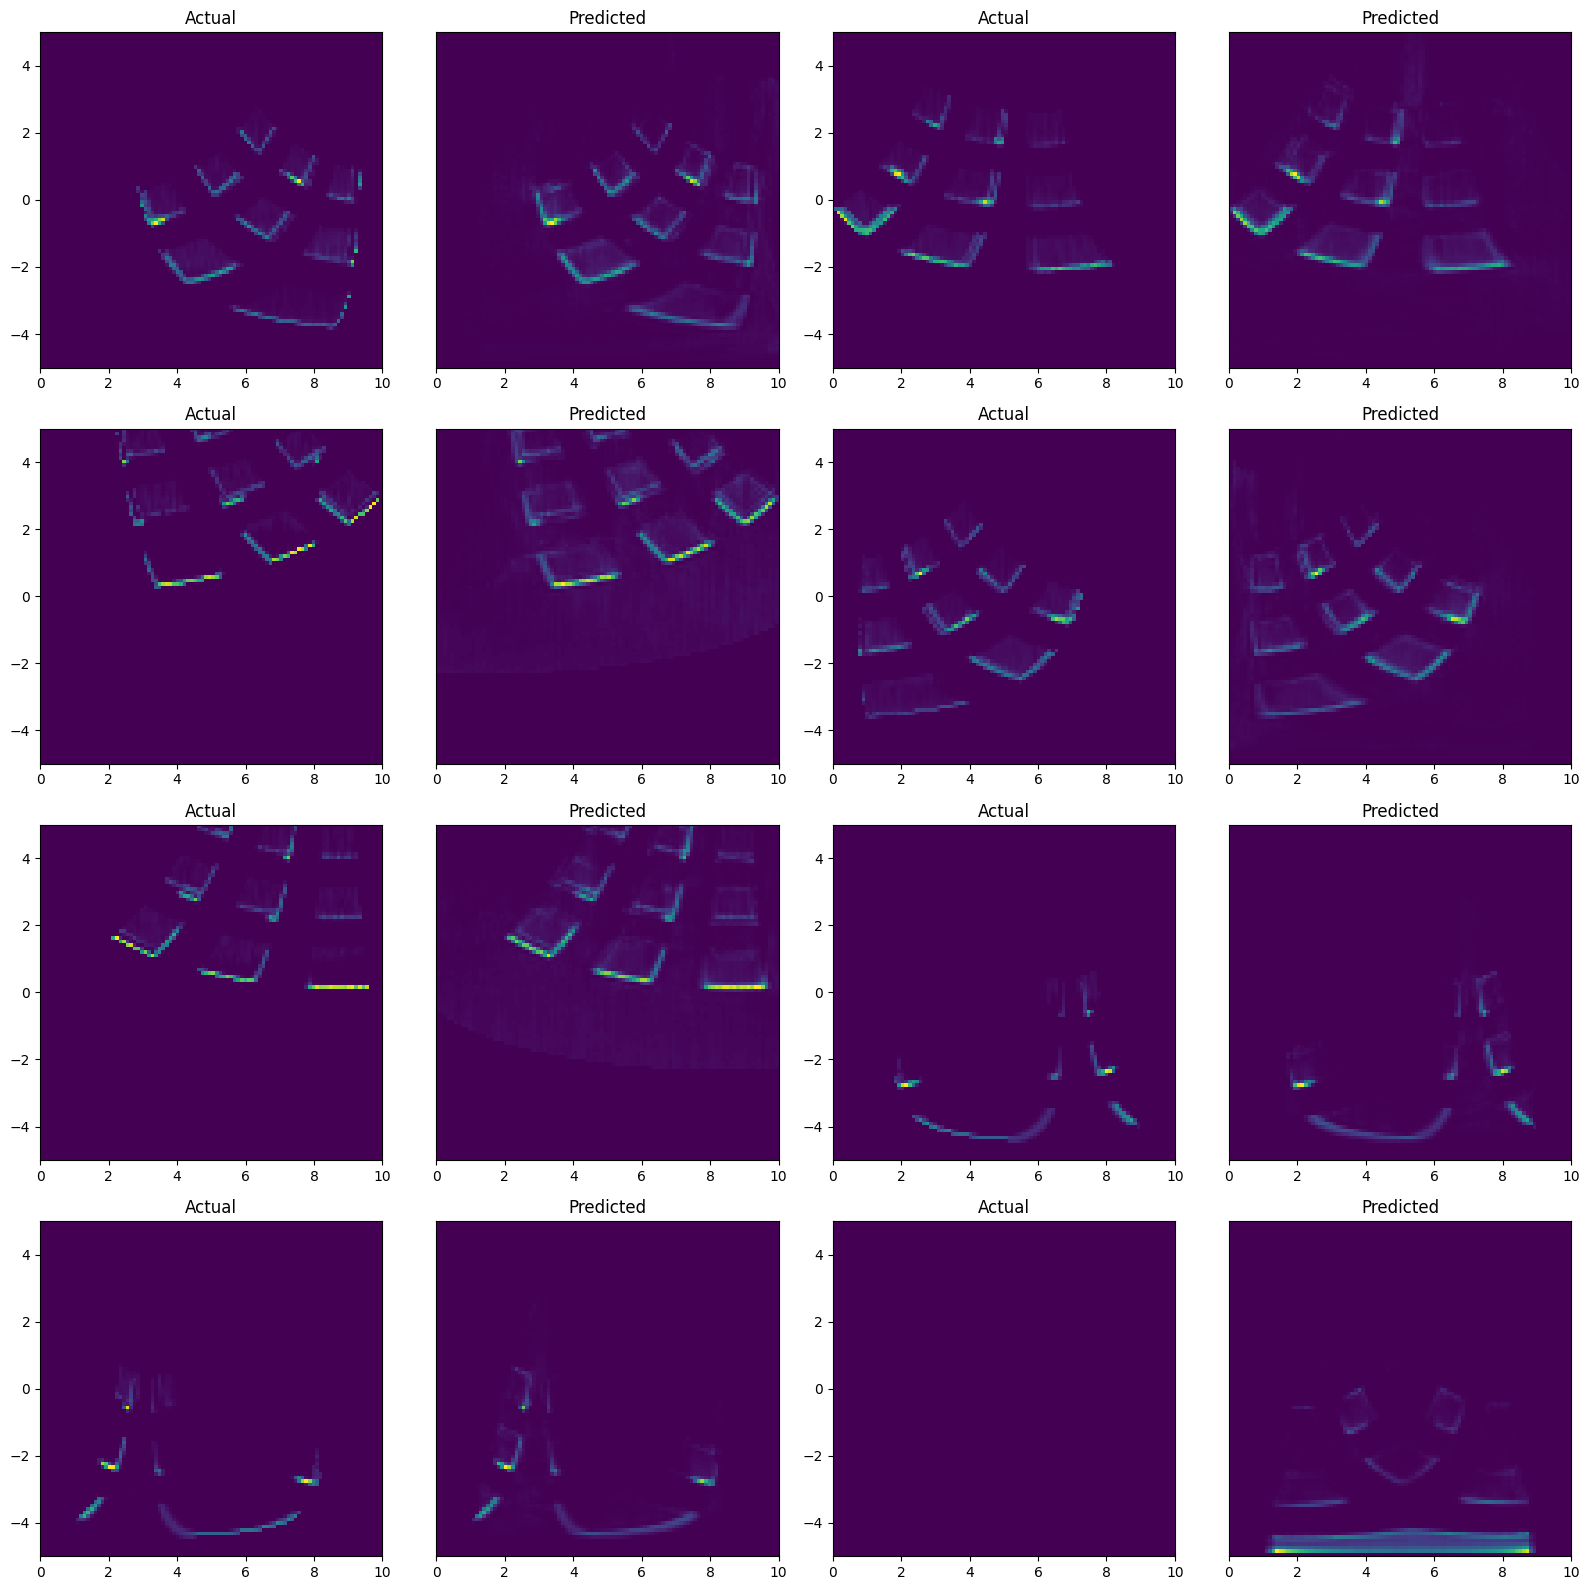

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for y_true, y_pred, pair in zip(images, predicted, axs.reshape(-1, 2)):
    sensor.plot_image(pair[0], y_true)
    sensor.plot_image(pair[1], y_pred)
    pair[0].set_title("Actual")
    pair[1].set_title("Predicted")
    pair[1].set_yticks([])

fig.tight_layout()